In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.backends import cudnn

In [4]:
from option import get_option, parser
from trainer import Trainer
from utils import save_option
import data_loader
import models

In [5]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
seed = 87
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [7]:
from urlnet_utils import *

In [8]:
min_word_freq = 1
max_len_words = 200
max_len_chars = 200
max_len_subwords = 20
delimit_mode = 1
dev_pct = 0.1

In [9]:
urls, labels = read_data("../URLNet/train_10000.txt")

high_freq_words = None
if min_word_freq > 0:
    x1, word_reverse_dict = get_word_vocab(urls, max_len_words, min_word_freq) 
    high_freq_words = sorted(list(word_reverse_dict.values()))
    print("Number of words with freq >={}: {}".format(min_word_freq, len(high_freq_words)))

x, word_reverse_dict = get_word_vocab(urls, max_len_words)
word_x = get_words(x, word_reverse_dict, delimit_mode, urls)
ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, max_len_subwords, high_freq_words)
reverse_dict = {words_dict[i]:i for i in words_dict}
chars_dict = ngrams_dict
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Overall Mal/Ben rate: {}/{}".format(np.sum(labels==1), np.sum(labels==0)))

########  shuffle & split  ######

shuffle_idx = np.random.permutation(np.arange(len(labels)))
train, test = prep_train_test(len(labels), dev_pct)
#y_train, y_test = to_categorical(labels[train], nb_classes=2), to_categorical(labels[test], nb_classes=2)
y_train, y_val = labels[train], labels[test]

x_train_char = ngramed_id_x[train]
x_val_char = ngramed_id_x[test]
x_train_word = pad_seq_in_word(worded_id_x[train], max_len_words)
x_val_word = pad_seq_in_word(worded_id_x[test], max_len_words)
x_train_char_seq = pad_seq_in_word(chared_id_x[train], max_len_chars)
x_val_char_seq = pad_seq_in_word(chared_id_x[test], max_len_chars)
print(x_train_word.shape, x_val_word.shape, x_train_char_seq.shape, x_val_char_seq.shape)

10/24/2019 18:20:49 - WARNING - tensorflow -   From /host/Proxy/learning-not-to-learn/urlnet_utils.py:113: VocabularyProcessor.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
10/24/2019 18:20:49 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:154: CategoricalVocabulary.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.categorical_vocabulary) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
10/24/2019 18:20:49 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:170: tokenizer (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future ver

Finished build vocabulary and mapping to x in 2.917095422744751
Size of word vocabulary: 17058
Number of words with freq >=1: 17058
Finished build vocabulary and mapping to x in 2.7871999740600586
Size of word vocabulary: 63443
Processing #url 0
Size of ngram vocabulary: 131
Size of word vocabulary: 16140
Index of <UNKNOWN> word: 4
Overall Mal/Ben rate: 23613/23613
(42504, 200) (4722, 200) (42504, 200) (4722, 200)


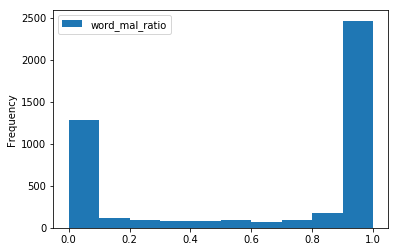

In [10]:
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=1)

if not os.path.isfile("word_mal_ratio.pkl"):
    df_tmp = pd.DataFrame({'token':word_x, "label":labels})
    word_mal_ratio = dict()

    for word in tqdm(words_dict):
        df_tmp['exist'] = df_tmp['token'].map(lambda x:word in x)
        cnt = len(df_tmp.query('exist == True & label == 0'))
        word_mal_ratio[word] = cnt / df_tmp.exist.sum()
    
    with open("word_mal_ratio.pkl", "wb") as f:
        pickle.dump(word_mal_ratio, f)
else:
    with open("word_mal_ratio.pkl", "rb") as f:
        word_mal_ratio = pickle.load(f)


tmp = [word_mal_ratio[i] for i in word_mal_ratio]
tmp = pd.DataFrame({'word_mal_ratio':tmp, 'word':[i for i in word_mal_ratio]})
tmp.plot(kind='hist')

In [11]:
tmp1 = words_dict
tmp2 = ngrams_dict

In [12]:
urls, labels = read_data("../URLNet/val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict) 
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test = labels
x_test_char = ngramed_id_x
x_test_word = pad_seq_in_word(worded_id_x, max_len_words)
x_test_char_seq = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word.shape, x_test_char_seq.shape, x_test_char_seq.shape)

Finished build vocabulary and mapping to x in 0.39143872261047363
Size of word vocabulary: 10884
Index of <UNKNOWN> word: 4
Processing url #0
Number of testing urls: 5248
(5248, 200) (5248, 200) (5248, 200)


In [13]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [14]:
urls, labels = read_data("../taipei/out.csv")#"../URLNet/test_10000.txt"
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict)
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test2 = labels
x_test_char2 = ngramed_id_x
x_test_word2 = pad_seq_in_word(worded_id_x, max_len_words)
x_test_char_seq2 = pad_seq_in_word(chared_id_x, max_len_chars)
print(x_test_word2.shape, x_test_char_seq2.shape, x_test_char_seq2.shape)

Finished build vocabulary and mapping to x in 149.07245707511902
Size of word vocabulary: 3865855
Index of <UNKNOWN> word: 4
Processing url #0
Processing url #100000
Processing url #200000
Processing url #300000
Processing url #400000
Processing url #500000
Processing url #600000
Processing url #700000
Processing url #800000
Processing url #900000
Processing url #1000000
Processing url #1100000
Processing url #1200000
Processing url #1300000
Processing url #1400000
Processing url #1500000
Processing url #1600000
Processing url #1700000
Number of testing urls: 1737594
(1737594, 200) (1737594, 200) (1737594, 200)


In [15]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [16]:
emb_dim = 32
l2_reg_lambda = 0.0
emb_mode = 2
filter_size = [3,4,5,6]
batch_size = 128
epochs = 5
lr = 1e-3

In [17]:
from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

train_dataset = mydata(x_train_word, y_train)
val_dataset = mydata(x_val_word, y_val)
test_dataset1 = mydata(x_test_word, y_test)
test_dataset2 = mydata(x_test_word2, y_test2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [18]:
def accuracy_thresh_sum(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    y_pred = F.sigmoid(y_pred)
    return ((y_pred>thresh)==y_true.byte()).float().sum().item()

def accuracy_thresh_score(y_pred, y_true, thresh:float=0.5):
    return ((y_pred>0.5).astype(int) == y_true).mean()

In [19]:
def soft_cross_entropy(inp, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * F.log_softmax(inp), dim=1))
    else:
        return torch.sum(torch.sum(-target * F.log_softmax(inp), dim=1))

class NegativeEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(NegativeEntropyLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = -1.0 * b.sum()
        return b

In [20]:
model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            kernel_sizes=filter_size).cuda()

print('paramters count', sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

paramters count 1354145


In [21]:
model

WordCNN(
  (word_emb): Embedding(16141, 32)
  (drop): Dropout(p=0.2)
  (convnet): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 32), stride=(1, 1))
    (1): Conv2d(1, 256, kernel_size=(4, 32), stride=(1, 1))
    (2): Conv2d(1, 256, kernel_size=(5, 32), stride=(1, 1))
    (3): Conv2d(1, 256, kernel_size=(6, 32), stride=(1, 1))
  )
  (maxpool): Sequential(
    (0): MaxPool2d(kernel_size=(198, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=(197, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): MaxPool2d(kernel_size=(196, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): MaxPool2d(kernel_size=(195, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
def step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.float().cuda()
            logits = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            all_logits.append(F.sigmoid(logits).detach().cpu().numpy())
            
            
    loss_total /= (len(loader)/batch_size)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_logits, all_labels)
    
    #logger.info(message)
    logger.info('Loss     : {}'.format(loss_total))
    logger.info('Accuracy : {}'.format(acc))
    logger.info('AUC      : {}'.format(auc))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc}

In [24]:
# start straining

history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
for e in tqdm(range(10), desc="Epoch"):
    train_result = step(model, optimizer, train_loader, train=True, message="Training :{}".format(e))
    valid_result = step(model, optimizer, val_loader, train=False, message="Validation :{}".format(e))
    test_result1 = step(model, optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
    test_result2 = step(model, optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))
    
    history['train'].append(train_result)
    history['valid'].append(valid_result)
    history['test1'].append(test_result1)
    history['test2'].append(test_result2)

10/24/2019 19:04:33 - INFO - __main__ -   Loss     : 1864.6982630571356
10/24/2019 19:04:33 - INFO - __main__ -   Accuracy : 0.9526868059476755
10/24/2019 19:04:33 - INFO - __main__ -   AUC      : 0.9918453183619272


10/24/2019 19:04:34 - INFO - __main__ -   Loss     : 409.2948219711716
10/24/2019 19:04:34 - INFO - __main__ -   Accuracy : 0.9913172384582803
10/24/2019 19:04:34 - INFO - __main__ -   AUC      : 0.9995620618823259


10/24/2019 19:04:34 - INFO - __main__ -   Loss     : 365.4121755041727
10/24/2019 19:04:34 - INFO - __main__ -   Accuracy : 0.993140243902439
10/24/2019 19:04:34 - INFO - __main__ -   AUC      : 0.9996857107004758


10/24/2019 19:08:58 - INFO - __main__ -   Loss     : 71942.25571878382
10/24/2019 19:08:58 - INFO - __main__ -   Accuracy : 0.09122153966922077
10/24/2019 19:08:58 - INFO - __main__ -   AUC      : 0.696759403493228


10/24/2019 19:09:12 - INFO - __main__ -   Loss     : 488.2739741098326
10/24/2019 19:09:12 - INFO - __main__ -   Accuracy : 0.9900009410878976
10/24/2019 19:09:12 - INFO - __main__ -   AUC      : 0.9992161033804301


10/24/2019 19:09:13 - INFO - __main__ -   Loss     : 245.82618837098818
10/24/2019 19:09:13 - INFO - __main__ -   Accuracy : 0.995129182549767
10/24/2019 19:09:13 - INFO - __main__ -   AUC      : 0.9998874181222708


10/24/2019 19:09:14 - INFO - __main__ -   Loss     : 260.50672623006307
10/24/2019 19:09:14 - INFO - __main__ -   Accuracy : 0.995045731707317
10/24/2019 19:09:14 - INFO - __main__ -   AUC      : 0.9999051613158091


10/24/2019 19:13:38 - INFO - __main__ -   Loss     : 63463.74656076564
10/24/2019 19:13:38 - INFO - __main__ -   Accuracy : 0.08620253062568126
10/24/2019 19:13:38 - INFO - __main__ -   AUC      : 0.7544474956596188


10/24/2019 19:13:53 - INFO - __main__ -   Loss     : 229.54138863308484
10/24/2019 19:13:53 - INFO - __main__ -   Accuracy : 0.995506305288914
10/24/2019 19:13:53 - INFO - __main__ -   AUC      : 0.9997829710267964


10/24/2019 19:13:54 - INFO - __main__ -   Loss     : 174.95988420538
10/24/2019 19:13:54 - INFO - __main__ -   Accuracy : 0.9963998305802626
10/24/2019 19:13:54 - INFO - __main__ -   AUC      : 0.9999141720294186


10/24/2019 19:13:55 - INFO - __main__ -   Loss     : 277.5185890430357
10/24/2019 19:13:55 - INFO - __main__ -   Accuracy : 0.9948551829268293
10/24/2019 19:13:55 - INFO - __main__ -   AUC      : 0.999818746281975


10/24/2019 19:18:20 - INFO - __main__ -   Loss     : 78516.41102512304
10/24/2019 19:18:20 - INFO - __main__ -   Accuracy : 0.08389186426748711
10/24/2019 19:18:20 - INFO - __main__ -   AUC      : 0.7805637917989674


10/24/2019 19:18:35 - INFO - __main__ -   Loss     : 140.38787146336077
10/24/2019 19:18:35 - INFO - __main__ -   Accuracy : 0.9970591003199699
10/24/2019 19:18:35 - INFO - __main__ -   AUC      : 0.999938048340685


10/24/2019 19:18:35 - INFO - __main__ -   Loss     : 144.09605570097227
10/24/2019 19:18:35 - INFO - __main__ -   Accuracy : 0.9972469292672597
10/24/2019 19:18:35 - INFO - __main__ -   AUC      : 0.999952597104114


10/24/2019 19:18:36 - INFO - __main__ -   Loss     : 294.0976618150385
10/24/2019 19:18:36 - INFO - __main__ -   Accuracy : 0.9923780487804879
10/24/2019 19:18:36 - INFO - __main__ -   AUC      : 0.9998653668296401


10/24/2019 19:23:02 - INFO - __main__ -   Loss     : 94612.4117811679
10/24/2019 19:23:02 - INFO - __main__ -   Accuracy : 0.07978503609013383
10/24/2019 19:23:02 - INFO - __main__ -   AUC      : 0.746460813766635


10/24/2019 19:23:17 - INFO - __main__ -   Loss     : 125.61351906322257
10/24/2019 19:23:17 - INFO - __main__ -   Accuracy : 0.9975061170713344
10/24/2019 19:23:17 - INFO - __main__ -   AUC      : 0.9999571851595362


10/24/2019 19:23:18 - INFO - __main__ -   Loss     : 98.04169505351298
10/24/2019 19:23:18 - INFO - __main__ -   Accuracy : 0.9987293519695044
10/24/2019 19:23:18 - INFO - __main__ -   AUC      : 0.9999515197655712


10/24/2019 19:23:19 - INFO - __main__ -   Loss     : 242.42487489850055
10/24/2019 19:23:19 - INFO - __main__ -   Accuracy : 0.9965701219512195
10/24/2019 19:23:19 - INFO - __main__ -   AUC      : 0.9999121326126561


10/24/2019 19:27:41 - INFO - __main__ -   Loss     : 122961.47931987121
10/24/2019 19:27:41 - INFO - __main__ -   Accuracy : 0.08472922903739309
10/24/2019 19:27:41 - INFO - __main__ -   AUC      : 0.7318619237256709


10/24/2019 19:27:55 - INFO - __main__ -   Loss     : 86.25849337660212
10/24/2019 19:27:55 - INFO - __main__ -   Accuracy : 0.9983295689817429
10/24/2019 19:27:55 - INFO - __main__ -   AUC      : 0.9999737469326483


10/24/2019 19:27:56 - INFO - __main__ -   Loss     : 348.3184262095271
10/24/2019 19:27:56 - INFO - __main__ -   Accuracy : 0.9913172384582803
10/24/2019 19:27:56 - INFO - __main__ -   AUC      : 0.9999775554470236


10/24/2019 19:27:57 - INFO - __main__ -   Loss     : 811.6156192432135
10/24/2019 19:27:57 - INFO - __main__ -   Accuracy : 0.9857088414634146
10/24/2019 19:27:57 - INFO - __main__ -   AUC      : 0.9999307953552573


10/24/2019 19:32:23 - INFO - __main__ -   Loss     : 51474.00140674867
10/24/2019 19:32:23 - INFO - __main__ -   Accuracy : 0.1572933608196161
10/24/2019 19:32:23 - INFO - __main__ -   AUC      : 0.6796382000498131


10/24/2019 19:32:38 - INFO - __main__ -   Loss     : 81.61845048125441
10/24/2019 19:32:38 - INFO - __main__ -   Accuracy : 0.9987060041407867
10/24/2019 19:32:38 - INFO - __main__ -   AUC      : 0.9999728324925018


10/24/2019 19:32:39 - INFO - __main__ -   Loss     : 2626.580193596917
10/24/2019 19:32:39 - INFO - __main__ -   Accuracy : 0.9392206692079628
10/24/2019 19:32:39 - INFO - __main__ -   AUC      : 0.9998883159043898


10/24/2019 19:32:40 - INFO - __main__ -   Loss     : 4207.7009145791935
10/24/2019 19:32:40 - INFO - __main__ -   Accuracy : 0.9096798780487805
10/24/2019 19:32:40 - INFO - __main__ -   AUC      : 0.9994192038314247


10/24/2019 19:37:04 - INFO - __main__ -   Loss     : 126814.48422024905
10/24/2019 19:37:04 - INFO - __main__ -   Accuracy : 0.0672308951343064
10/24/2019 19:37:04 - INFO - __main__ -   AUC      : 0.7990149621173127


10/24/2019 19:37:19 - INFO - __main__ -   Loss     : 105.08616030094838
10/24/2019 19:37:19 - INFO - __main__ -   Accuracy : 0.9979766610201393
10/24/2019 19:37:19 - INFO - __main__ -   AUC      : 0.9999570888444119


10/24/2019 19:37:20 - INFO - __main__ -   Loss     : 159.15692963471284
10/24/2019 19:37:20 - INFO - __main__ -   Accuracy : 0.9966116052520119
10/24/2019 19:37:20 - INFO - __main__ -   AUC      : 0.9999811465754999


10/24/2019 19:37:21 - INFO - __main__ -   Loss     : 218.21816090839664
10/24/2019 19:37:21 - INFO - __main__ -   Accuracy : 0.9959984756097561
10/24/2019 19:37:21 - INFO - __main__ -   AUC      : 0.9999227347932778


10/24/2019 19:41:46 - INFO - __main__ -   Loss     : 87794.19051670394
10/24/2019 19:41:46 - INFO - __main__ -   Accuracy : 0.07401786608379173
10/24/2019 19:41:46 - INFO - __main__ -   AUC      : 0.7922601084019637


10/24/2019 19:42:01 - INFO - __main__ -   Loss     : 39.0338412457266
10/24/2019 19:42:01 - INFO - __main__ -   Accuracy : 0.9992941840767928
10/24/2019 19:42:01 - INFO - __main__ -   AUC      : 0.9999904703380382


10/24/2019 19:42:02 - INFO - __main__ -   Loss     : 73.05124307605061
10/24/2019 19:42:02 - INFO - __main__ -   Accuracy : 0.9983058026260059
10/24/2019 19:42:02 - INFO - __main__ -   AUC      : 0.9999815056883475


10/24/2019 19:42:03 - INFO - __main__ -   Loss     : 292.63581065581377
10/24/2019 19:42:03 - INFO - __main__ -   Accuracy : 0.9961890243902439
10/24/2019 19:42:03 - INFO - __main__ -   AUC      : 0.9999416880065809


10/24/2019 19:46:29 - INFO - __main__ -   Loss     : 108308.39381614915
10/24/2019 19:46:29 - INFO - __main__ -   Accuracy : 0.09292446912224604
10/24/2019 19:46:29 - INFO - __main__ -   AUC      : 0.7027385430614665


10/24/2019 19:46:44 - INFO - __main__ -   Loss     : 39.533802862894404
10/24/2019 19:46:44 - INFO - __main__ -   Accuracy : 0.999129493694711
10/24/2019 19:46:44 - INFO - __main__ -   AUC      : 0.9999957466355416


10/24/2019 19:46:45 - INFO - __main__ -   Loss     : 52.62176669796778
10/24/2019 19:46:45 - INFO - __main__ -   Accuracy : 0.9991529013130029
10/24/2019 19:46:45 - INFO - __main__ -   AUC      : 0.9999841990347047


10/24/2019 19:46:45 - INFO - __main__ -   Loss     : 299.00582164732856
10/24/2019 19:46:45 - INFO - __main__ -   Accuracy : 0.9969512195121951
10/24/2019 19:46:45 - INFO - __main__ -   AUC      : 0.999940671359124


10/24/2019 19:51:11 - INFO - __main__ -   Loss     : 108500.05738619818
10/24/2019 19:51:11 - INFO - __main__ -   Accuracy : 0.09437244833948552
10/24/2019 19:51:11 - INFO - __main__ -   AUC      : 0.7332607732307429


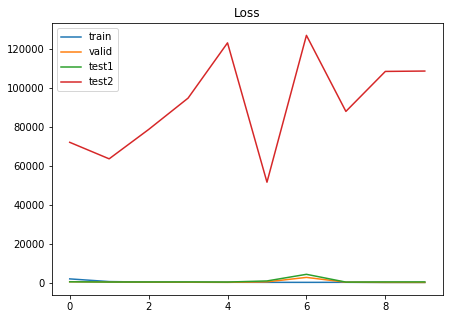

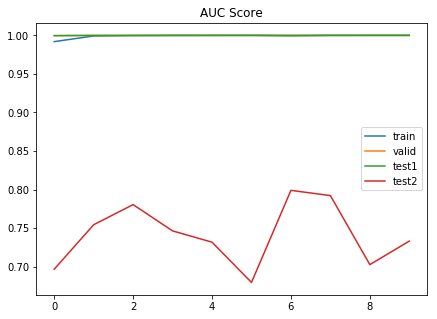

In [25]:
save = "baseline"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_loss.png')
    plt.savefig(path)
plt.show()

plt.figure(figsize=(7,5))
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_auc.png')
    plt.savefig(path)
plt.show()

# Adversarial training

In [26]:
UNKId = words_dict['<UNKNOWN>']
word_mal_ratio['<UNKNOWN>'] = 0.5
data = list(map(lambda x:words_dict.get(x, UNKId), word_mal_ratio.keys()))
label = list(map(lambda x:np.array([x, 1-x]), word_mal_ratio.values()))

emb_ratio_dataset = mydata(data, label)
emb_ratio_loader = DataLoader(emb_ratio_dataset, batch_size=batch_size, shuffle=True)

In [27]:
d, l = next(iter(emb_ratio_loader))
d.unsqueeze(1).shape

torch.Size([128, 1])

In [29]:
def emb_step(model, optimizer, train=False):
    
    loader = emb_ratio_loader
    loss_total = 0
    _lambda = 0.1
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    with mode():
        for (data, label) in loader:
        #for (data, label) in tqdm(loader, desc="emb bias"):
            data, label = data.long().unsqueeze(1).cuda(), label.float().cuda()
            logits = model(data)
            loss = soft_cross_entropy(logits, label, size_average=True) * _lambda
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
    loss_total /= (len(loader)/batch_size)
    return loss_total

In [30]:
def adv_step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    bias_loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    bias_model.train if train else bias_model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (data, label) in tqdm(loader, desc=message):
            data, label = data.long().cuda(), label.float().cuda()
            logits = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            all_logits.append(F.sigmoid(logits).detach().cpu().numpy())
            
#             ###adv step for each original batch
#             logits = bias_model(data).squeeze()
#             _lambda = 0.01
#             bias_loss = _lambda * soft_cross_entropy(logits)
#             if train:
#                 bias_loss.backward()
#                 bias__optimizer.step()
#                 bias__optimizer.zero_grad()
#             bias_loss_total += bias_loss.item()
#     bias_loss_total = bias_loss_total/(len(loader)/batch_size
    
    loss_total /= (len(loader)/batch_size)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_logits, all_labels)
    

    bias_loss_total = emb_step(bias_model, bias_optimizer, train)
    logger.info('Loss     : {}'.format(loss_total))
    logger.info('Bias Loss: {}'.format(bias_loss_total))
    logger.info('Accuracy : {}'.format(acc))
    logger.info('AUC      : {}'.format(auc))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc, "bias":bias_loss_total}

In [31]:
adv_model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            kernel_sizes=filter_size).cuda()
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3)

bias_model = models.BiasPredictor(adv_model.word_emb, emb_dim).cuda()
bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=1e-3)

In [32]:
# start straining

history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
for e in tqdm(range(10), desc="Epoch"):
    train_result = adv_step(adv_model, adv_optimizer, train_loader, train=True, message="Training :{}".format(e))
    valid_result = adv_step(adv_model, adv_optimizer, val_loader, train=False, message="Validation :{}".format(e))
    test_result1 = adv_step(adv_model, adv_optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
    test_result2 = adv_step(adv_model, adv_optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))
    
    history['train'].append(train_result)
    history['valid'].append(valid_result)
    history['test1'].append(test_result1)
    history['test2'].append(test_result2)

10/25/2019 01:22:58 - INFO - __main__ -   Loss     : 1900.1325647043395
10/25/2019 01:22:58 - INFO - __main__ -   Bias Loss: 8.563753737343681
10/25/2019 01:22:58 - INFO - __main__ -   Accuracy : 0.9523338979860719
10/25/2019 01:22:58 - INFO - __main__ -   AUC      : 0.9915522402949963


10/25/2019 01:22:59 - INFO - __main__ -   Loss     : 273.68482971191406
10/25/2019 01:22:59 - INFO - __main__ -   Bias Loss: 8.514204833242628
10/25/2019 01:22:59 - INFO - __main__ -   Accuracy : 0.9953409572215163
10/25/2019 01:22:59 - INFO - __main__ -   AUC      : 0.9998060790622845


10/25/2019 01:23:00 - INFO - __main__ -   Loss     : 365.072212730966
10/25/2019 01:23:00 - INFO - __main__ -   Bias Loss: 8.482215060128105
10/25/2019 01:23:00 - INFO - __main__ -   Accuracy : 0.9933307926829268
10/25/2019 01:23:00 - INFO - __main__ -   AUC      : 0.9997192600665527


10/25/2019 01:27:28 - INFO - __main__ -   Loss     : 50092.58398080675
10/25/2019 01:27:28 - INFO - __main__ -   Bias Loss: 8.520226332876417
10/25/2019 01:27:28 - INFO - __main__ -   Accuracy : 0.085083166723642
10/25/2019 01:27:28 - INFO - __main__ -   AUC      : 0.8174932011449937


10/25/2019 01:27:43 - INFO - __main__ -   Loss     : 455.97039504474526
10/25/2019 01:27:43 - INFO - __main__ -   Bias Loss: 8.467684653070238
10/25/2019 01:27:43 - INFO - __main__ -   Accuracy : 0.9904009034443817
10/25/2019 01:27:43 - INFO - __main__ -   AUC      : 0.9994016605564389


10/25/2019 01:27:44 - INFO - __main__ -   Loss     : 196.32109635585064
10/25/2019 01:27:44 - INFO - __main__ -   Bias Loss: 8.492855389912924
10/25/2019 01:27:44 - INFO - __main__ -   Accuracy : 0.9961880559085133
10/25/2019 01:27:44 - INFO - __main__ -   AUC      : 0.9999220725120661


10/25/2019 01:27:45 - INFO - __main__ -   Loss     : 313.27609978652583
10/25/2019 01:27:45 - INFO - __main__ -   Bias Loss: 8.490340948104858
10/25/2019 01:27:45 - INFO - __main__ -   Accuracy : 0.9939024390243902
10/25/2019 01:27:45 - INFO - __main__ -   AUC      : 0.9997770637362433


10/25/2019 01:32:12 - INFO - __main__ -   Loss     : 40398.58191983095
10/25/2019 01:32:12 - INFO - __main__ -   Bias Loss: 8.464546336068047
10/25/2019 01:32:12 - INFO - __main__ -   Accuracy : 0.17368902056521834
10/25/2019 01:32:12 - INFO - __main__ -   AUC      : 0.8379244067954742


10/25/2019 01:32:27 - INFO - __main__ -   Loss     : 258.9509734951027
10/25/2019 01:32:27 - INFO - __main__ -   Bias Loss: 8.425539400842455
10/25/2019 01:32:27 - INFO - __main__ -   Accuracy : 0.9948710709580275
10/25/2019 01:32:27 - INFO - __main__ -   AUC      : 0.9997612968025994


10/25/2019 01:32:28 - INFO - __main__ -   Loss     : 349.29198961000185
10/25/2019 01:32:28 - INFO - __main__ -   Bias Loss: 8.432827605141533
10/25/2019 01:32:28 - INFO - __main__ -   Accuracy : 0.9947056332062685
10/25/2019 01:32:28 - INFO - __main__ -   AUC      : 0.9999560086761664


10/25/2019 01:32:29 - INFO - __main__ -   Loss     : 739.9553019535251
10/25/2019 01:32:29 - INFO - __main__ -   Bias Loss: 8.43601844045851
10/25/2019 01:32:29 - INFO - __main__ -   Accuracy : 0.9887576219512195
10/25/2019 01:32:29 - INFO - __main__ -   AUC      : 0.9997301527178762


10/25/2019 01:36:57 - INFO - __main__ -   Loss     : 92104.13949268674
10/25/2019 01:36:57 - INFO - __main__ -   Bias Loss: 8.423695021205479
10/25/2019 01:36:57 - INFO - __main__ -   Accuracy : 0.0762168838059984
10/25/2019 01:36:57 - INFO - __main__ -   AUC      : 0.8522289501268913


10/25/2019 01:37:12 - INFO - __main__ -   Loss     : 143.1404783643164
10/25/2019 01:37:12 - INFO - __main__ -   Bias Loss: 8.43326551384396
10/25/2019 01:37:12 - INFO - __main__ -   Accuracy : 0.9974355354790138
10/25/2019 01:37:12 - INFO - __main__ -   AUC      : 0.999906496834422


10/25/2019 01:37:13 - INFO - __main__ -   Loss     : 132.5511423897099
10/25/2019 01:37:13 - INFO - __main__ -   Bias Loss: 8.423222343126932
10/25/2019 01:37:13 - INFO - __main__ -   Accuracy : 0.9976704786107582
10/25/2019 01:37:13 - INFO - __main__ -   AUC      : 0.9999692958515284


10/25/2019 01:37:14 - INFO - __main__ -   Loss     : 381.9750531955463
10/25/2019 01:37:14 - INFO - __main__ -   Bias Loss: 8.415922231144375
10/25/2019 01:37:14 - INFO - __main__ -   Accuracy : 0.9952362804878049
10/25/2019 01:37:14 - INFO - __main__ -   AUC      : 0.9997757566180845


10/25/2019 01:41:41 - INFO - __main__ -   Loss     : 75056.86302381504
10/25/2019 01:41:41 - INFO - __main__ -   Bias Loss: 8.401514609654745
10/25/2019 01:41:41 - INFO - __main__ -   Accuracy : 0.09038359939088188
10/25/2019 01:41:41 - INFO - __main__ -   AUC      : 0.8344197671425599


10/25/2019 01:41:56 - INFO - __main__ -   Loss     : 92.60686407110363
10/25/2019 01:41:56 - INFO - __main__ -   Bias Loss: 8.40221749411689
10/25/2019 01:41:56 - INFO - __main__ -   Accuracy : 0.9984236777715039
10/25/2019 01:41:56 - INFO - __main__ -   AUC      : 0.9999618547824631


10/25/2019 01:41:57 - INFO - __main__ -   Loss     : 228.5946983904452
10/25/2019 01:41:57 - INFO - __main__ -   Bias Loss: 8.411830173598396
10/25/2019 01:41:57 - INFO - __main__ -   Accuracy : 0.9970351545955104
10/25/2019 01:41:57 - INFO - __main__ -   AUC      : 0.9999565473454378


10/25/2019 01:41:58 - INFO - __main__ -   Loss     : 537.9183979608664
10/25/2019 01:41:58 - INFO - __main__ -   Bias Loss: 8.410408046510485
10/25/2019 01:41:58 - INFO - __main__ -   Accuracy : 0.9937118902439024
10/25/2019 01:41:58 - INFO - __main__ -   AUC      : 0.9996203547925342


10/25/2019 01:46:26 - INFO - __main__ -   Loss     : 77887.2102097346
10/25/2019 01:46:26 - INFO - __main__ -   Bias Loss: 8.392343746291267
10/25/2019 01:46:26 - INFO - __main__ -   Accuracy : 0.09259988236607632
10/25/2019 01:46:26 - INFO - __main__ -   AUC      : 0.848789902154744


10/25/2019 01:46:41 - INFO - __main__ -   Loss     : 99.80040259189329
10/25/2019 01:46:41 - INFO - __main__ -   Bias Loss: 8.404217097494337
10/25/2019 01:46:41 - INFO - __main__ -   Accuracy : 0.9979296066252588
10/25/2019 01:46:41 - INFO - __main__ -   AUC      : 0.9999566161253531


10/25/2019 01:46:42 - INFO - __main__ -   Loss     : 177.72224428323474
10/25/2019 01:46:42 - INFO - __main__ -   Bias Loss: 8.424016965760124
10/25/2019 01:46:42 - INFO - __main__ -   Accuracy : 0.9966116052520119
10/25/2019 01:46:42 - INFO - __main__ -   AUC      : 0.9998139795449322


10/25/2019 01:46:43 - INFO - __main__ -   Loss     : 459.57634374008245
10/25/2019 01:46:43 - INFO - __main__ -   Bias Loss: 8.409284644656712
10/25/2019 01:46:43 - INFO - __main__ -   Accuracy : 0.9933307926829268
10/25/2019 01:46:43 - INFO - __main__ -   AUC      : 0.9998477933521712


10/25/2019 01:51:11 - INFO - __main__ -   Loss     : 52775.35969581732
10/25/2019 01:51:11 - INFO - __main__ -   Bias Loss: 8.41496291425493
10/25/2019 01:51:11 - INFO - __main__ -   Accuracy : 0.17070443383206893
10/25/2019 01:51:11 - INFO - __main__ -   AUC      : 0.8214789238180304


10/25/2019 01:51:26 - INFO - __main__ -   Loss     : 95.84248830981318
10/25/2019 01:51:26 - INFO - __main__ -   Bias Loss: 8.403158995840284
10/25/2019 01:51:26 - INFO - __main__ -   Accuracy : 0.9979296066252588
10/25/2019 01:51:26 - INFO - __main__ -   AUC      : 0.9999693928247839


10/25/2019 01:51:27 - INFO - __main__ -   Loss     : 88.07607579231262
10/25/2019 01:51:27 - INFO - __main__ -   Bias Loss: 8.395363105667961
10/25/2019 01:51:27 - INFO - __main__ -   Accuracy : 0.9980940279542567
10/25/2019 01:51:27 - INFO - __main__ -   AUC      : 0.9998926252585613


10/25/2019 01:51:28 - INFO - __main__ -   Loss     : 312.9245265849253
10/25/2019 01:51:28 - INFO - __main__ -   Bias Loss: 8.422692749235365
10/25/2019 01:51:28 - INFO - __main__ -   Accuracy : 0.9935213414634146
10/25/2019 01:51:28 - INFO - __main__ -   AUC      : 0.9998726285971893


10/25/2019 01:55:57 - INFO - __main__ -   Loss     : 50184.88938338059
10/25/2019 01:55:57 - INFO - __main__ -   Bias Loss: 8.412694838311937
10/25/2019 01:55:57 - INFO - __main__ -   Accuracy : 0.13932311000153086
10/25/2019 01:55:57 - INFO - __main__ -   AUC      : 0.8266549049915632


10/25/2019 01:56:12 - INFO - __main__ -   Loss     : 68.88319346371225
10/25/2019 01:56:12 - INFO - __main__ -   Bias Loss: 8.402462482452393
10/25/2019 01:56:12 - INFO - __main__ -   Accuracy : 0.9987060041407867
10/25/2019 01:56:12 - INFO - __main__ -   AUC      : 0.9999800384137042


10/25/2019 01:56:13 - INFO - __main__ -   Loss     : 117.3985993819865
10/25/2019 01:56:13 - INFO - __main__ -   Bias Loss: 8.409294287363688
10/25/2019 01:56:13 - INFO - __main__ -   Accuracy : 0.9985175772977551
10/25/2019 01:56:13 - INFO - __main__ -   AUC      : 0.9999486468627902


10/25/2019 01:56:14 - INFO - __main__ -   Loss     : 441.9302119216541
10/25/2019 01:56:14 - INFO - __main__ -   Bias Loss: 8.39783427450392
10/25/2019 01:56:14 - INFO - __main__ -   Accuracy : 0.9946646341463414
10/25/2019 01:56:14 - INFO - __main__ -   AUC      : 0.9998302924923781


10/25/2019 02:00:43 - INFO - __main__ -   Loss     : 98515.17270962756
10/25/2019 02:00:43 - INFO - __main__ -   Bias Loss: 8.409151434898376
10/25/2019 02:00:43 - INFO - __main__ -   Accuracy : 0.0927259187128869
10/25/2019 02:00:43 - INFO - __main__ -   AUC      : 0.8039188323240246


10/25/2019 02:00:58 - INFO - __main__ -   Loss     : 59.62219554398421
10/25/2019 02:00:58 - INFO - __main__ -   Bias Loss: 8.421056747436523
10/25/2019 02:00:58 - INFO - __main__ -   Accuracy : 0.9989177489177489
10/25/2019 02:00:58 - INFO - __main__ -   AUC      : 0.9999840570792388


10/25/2019 02:00:59 - INFO - __main__ -   Loss     : 118.22185786390627
10/25/2019 02:00:59 - INFO - __main__ -   Bias Loss: 8.412004682752821
10/25/2019 02:00:59 - INFO - __main__ -   Accuracy : 0.9987293519695044
10/25/2019 02:00:59 - INFO - __main__ -   AUC      : 0.9999371552516663


10/25/2019 02:01:00 - INFO - __main__ -   Loss     : 406.8956871476115
10/25/2019 02:01:00 - INFO - __main__ -   Bias Loss: 8.420838647418552
10/25/2019 02:01:00 - INFO - __main__ -   Accuracy : 0.9961890243902439
10/25/2019 02:01:00 - INFO - __main__ -   AUC      : 0.9998123559265318


10/25/2019 02:05:28 - INFO - __main__ -   Loss     : 100038.23977981367
10/25/2019 02:05:28 - INFO - __main__ -   Bias Loss: 8.409459326002333
10/25/2019 02:05:28 - INFO - __main__ -   Accuracy : 0.0874847634142383
10/25/2019 02:05:28 - INFO - __main__ -   AUC      : 0.8122202093470505


10/25/2019 02:05:43 - INFO - __main__ -   Loss     : 33.666409334956526
10/25/2019 02:05:43 - INFO - __main__ -   Bias Loss: 8.419004122416178
10/25/2019 02:05:43 - INFO - __main__ -   Accuracy : 0.9992471296819123
10/25/2019 02:05:43 - INFO - __main__ -   AUC      : 0.9999956425709245


10/25/2019 02:05:44 - INFO - __main__ -   Loss     : 413.53348095352584
10/25/2019 02:05:44 - INFO - __main__ -   Bias Loss: 8.406515174441868
10/25/2019 02:05:44 - INFO - __main__ -   Accuracy : 0.9932232105040237
10/25/2019 02:05:44 - INFO - __main__ -   AUC      : 0.9999021417490233


10/25/2019 02:05:45 - INFO - __main__ -   Loss     : 632.610844183732
10/25/2019 02:05:45 - INFO - __main__ -   Bias Loss: 8.40888175699446
10/25/2019 02:05:45 - INFO - __main__ -   Accuracy : 0.9925685975609756
10/25/2019 02:05:45 - INFO - __main__ -   AUC      : 0.9998380625836555


10/25/2019 02:10:13 - INFO - __main__ -   Loss     : 32536.69684151501
10/25/2019 02:10:13 - INFO - __main__ -   Bias Loss: 8.384644031524658
10/25/2019 02:10:13 - INFO - __main__ -   Accuracy : 0.22533744936964561
10/25/2019 02:10:13 - INFO - __main__ -   AUC      : 0.7991508658802573


In [ ]:
save = "adv"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_bloss = [l['bias_loss'] for l in history['train']]
valid_bloss = [l['bias_loss'] for l in history['valid']]
test1_bloss = [l['bias_loss'] for l in history['test1']]
test2_bloss = [l['bias_loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_loss.png')
    plt.savefig(path)
plt.show()


plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_bloss, label='train')
plt.plot(valid_bloss, label='valid')
plt.plot(test1_bloss, label='test1')
plt.plot(test2_bloss, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_bias_loss.png')
    plt.savefig(path)
plt.show()


plt.figure(figsize=(7,5))
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
if save:
    path = os.path.join("output", save+'_auc.png')
    plt.savefig(path)
plt.show()